# kdTree

Creates a kdTree from the DNS data, enabling you to find C_my by using the kdTree as a lookup table.

Then the estimated C_my is compared to the actual C_my to see how well the kdTree works.

### Brute Force Solution

In [1431]:
# Libraries:

# Data manipulation
import numpy as np
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as sm
from sklearn.model_selection import train_test_split

# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm

# Calculations
from gradients import compute_face_phi, dphidx, dphidy, init
import scipy as sp
import scipy.spatial
import scipy.spatial.distance as distance
from scipy.spatial import KDTree, cKDTree

# Others
import time
import sys
import warnings
import matplotlib.cbook

Create the KDTree

### Read & manipulate DNS data

Choose case among   
small_wave/     
large_wave/     
one_hill/   
two_hills/

In [1432]:
DNS_file_path = "small_wave/"

In [1433]:
# Load data from tec and mesh files
tec = np.genfromtxt(DNS_file_path + "tec.dat", dtype=None, comments="%")
cell_faces = np.loadtxt(DNS_file_path + "mesh.dat")

In [1434]:
# Assign parameters
x_center = tec[:, 0]
y_center = tec[:, 1] 
pressure = tec[:, 2]
x_velocity = tec[:, 3]
y_velocity = tec[:, 4]
x_stress = tec[:, 5]  # stress tensor normal to x
y_stress = tec[:, 6]  # stress tensor normal to y
z_stress = tec[:, 7]  # stress tensor normal to z
xy_stress = tec[:, 8]  # stress tensor normal to x & y
kinetic_energy = 0.5 * (x_stress + y_stress + z_stress)  # Turbulent kinetic energy
epsilon = tec[:, 9]  # Dissipation rate

In [1435]:
# Define nxm matrix dimensions
if max(y_center) == 1.:
    n = 194
    m = 170
    viscosity = 1. / 10000.
else:
    viscosity = 1. / 10595.
    if max(x_center) > 8.:
        n = 162
        m = 162
    else:
        n = 162
        m = 402

In [1436]:
# Function that takes many arrays and reshapes them to nxm matrices
def reshape(*args, n, m):
    return [np.reshape(arg, (n, m)) for arg in args]

In [1437]:
def transpose(*args):
    return [np.transpose(arg) for arg in args]

In [1438]:
# Reshape & transpose all arrays
x_center, y_center, pressure, x_velocity, y_velocity, x_stress, y_stress, z_stress, xy_stress, kinetic_energy, epsilon = reshape(x_center, y_center, pressure, x_velocity, y_velocity, x_stress, y_stress, z_stress, xy_stress, kinetic_energy, epsilon, n=n, m=m)
x_center, y_center, pressure, x_velocity, y_velocity, x_stress, y_stress, z_stress, xy_stress, kinetic_energy, epsilon = transpose(x_center, y_center, pressure, x_velocity, y_velocity, x_stress, y_stress, z_stress, xy_stress, kinetic_energy, epsilon)

In [1439]:
# Set boundary conditions

# Set Neumann boundary conditions of p at upper and lower boundaries
pressure[:, 1] = pressure[:, 2]
pressure[:, -1] = pressure[:, -1 - 1]

# Set periodic b.c on west boundary so that the east & west boundaries are connected
x_velocity[0, :] = x_velocity[-1, :]
y_velocity[0, :] = y_velocity[-1, :]
pressure[0, :] = pressure[-1, :]
x_stress[0, :] = x_stress[-1, :]

In [1440]:
# Assign cell faces from data file xc_yc.dat
# They are needed for the dphidx_dy routine

x_face = cell_faces[:, 0]
y_face = cell_faces[:, 1]
x_face = np.reshape(x_face, (n - 1, m - 1))
y_face = np.reshape(y_face, (n - 1, m - 1))
x_face = np.transpose(x_face)
y_face = np.transpose(y_face)

In [1441]:
# Compute new cell centers
x_center_average = 0.25 * (x_center[0:-1, 0:-1] + x_center[0:-1, 1:] + x_center[1:, 0:-1] + x_center[1:, 1:])
y_center_average = 0.25 * (y_center[0:-1, 0:-1] + y_center[0:-1, 1:] + y_center[1:, 0:-1] + y_center[1:, 1:])

In [1442]:
def delete_rows(*args, rows):
    return [np.delete(arg, rows, axis=0) for arg in args]

In [1443]:
def delete_columns(*args, columns):
    return [np.delete(arg, columns, axis=1) for arg in args]

In [1444]:
# Delete the last row & column of every parameter
x_center, y_center, x_center_average, y_center_average, pressure, x_velocity, y_velocity, x_stress, y_stress, z_stress, xy_stress, kinetic_energy, epsilon = delete_rows(x_center, y_center, x_center_average, y_center_average, pressure, x_velocity, y_velocity, x_stress, y_stress, z_stress, xy_stress, kinetic_energy, epsilon, rows=-1)
x_center, y_center, x_center_average, y_center_average, pressure, x_velocity, y_velocity, x_stress, y_stress, z_stress, xy_stress, kinetic_energy, epsilon = delete_columns(x_center, y_center, x_center_average, y_center_average, pressure, x_velocity, y_velocity, x_stress, y_stress, z_stress, xy_stress, kinetic_energy, epsilon, columns=-1)

In [1445]:
# Delete the first row & column of every parameter except x_center & y_center
pressure, x_velocity, y_velocity, x_stress, y_stress, z_stress, xy_stress, kinetic_energy, epsilon = delete_rows(pressure, x_velocity, y_velocity, x_stress, y_stress, z_stress, xy_stress, kinetic_energy, epsilon, rows=0)
pressure, x_velocity, y_velocity, x_stress, y_stress, z_stress, xy_stress, kinetic_energy, epsilon = delete_columns(pressure, x_velocity, y_velocity, x_stress, y_stress, z_stress, xy_stress, kinetic_energy, epsilon, columns=0)

In [1446]:
# compute geometric quantities
areaw, areawx, areawy, areas, areasx, areasy, vol, fx, fy = init(x_center, y_center, x_center_average, y_center_average)

In [1447]:
# Adjust matrix dimensions
n = n - 2 
m = m - 2

In [1448]:
# Adjust epsilon at last cell upper cell
epsilon[:, -1] = epsilon[:, -2]

In [1449]:
# Compute face value of U and V
x_velocity_west, x_velocity_south = compute_face_phi(x_velocity, fx, fy, m, n)
y_velocity_west, y_velocity_south = compute_face_phi(y_velocity, fx, fy, m, n)

# x derivatives
dudx = dphidx(x_velocity_west, x_velocity_south, areawx, areasx, vol)
dvdx = dphidx(y_velocity_west, y_velocity_south, areawx, areasx, vol)

# y derivatives
dudy = dphidy(x_velocity_west, x_velocity_south, areawy, areasy, vol)
dvdy = dphidy(y_velocity_west, y_velocity_south, areawy, areasy, vol)

In [1450]:
# Calculate correct C_my for prediction
omega = epsilon / kinetic_energy / 0.09
c_my = np.array(-xy_stress / (kinetic_energy * (dudy + dvdx)) * omega)

/var/folders/19/k6d12h6s6hng1s70_0wscmh80000gn/T/ipykernel_71188/195559492.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


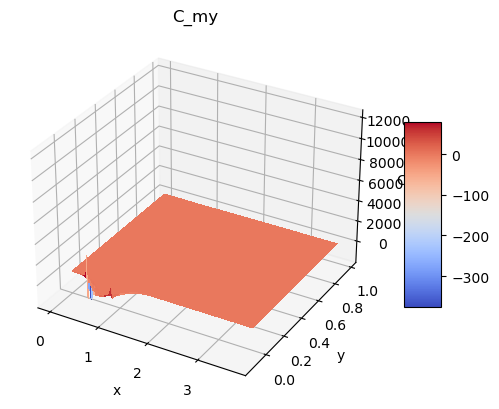

In [1451]:
# Plot 3D surface of C_my
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x_center_average, y_center_average, c_my, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('C_my')
ax.set_title('C_my')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [1452]:
# Adjust C_my with the first method
cmy_DNS = np.where(c_my > 0, c_my, 1)
cmy_DNS = np.where(cmy_DNS <= 2, cmy_DNS, 1)

/var/folders/19/k6d12h6s6hng1s70_0wscmh80000gn/T/ipykernel_71188/3139527718.py:5: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


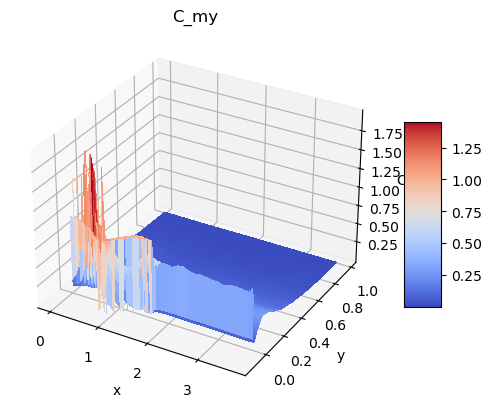

In [1453]:
# Plot 3D surface of cmy_DNS
# Why is the plot the same as the one above?
# The cmy_DNS array is the same as the c_my array because the np
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x_center_average, y_center_average, cmy_DNS, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('C_my')
ax.set_title('C_my')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [1454]:
c_my_tree = KDTree(c_my)

In [1455]:
# Function for calculating the sum of the distance between a point and its k nearest neighbors
def sum_of_distances(node, k):
    distance, index = c_my_tree.query(node, k=k)
    return np.sum(distance)

In [1456]:
# Function for finding the radius of the k nearest neighbors
def radius_of_knn(node, k):
    distance, index = c_my_tree.query(node, k=k)
    return distance[-1]

In [1457]:
# Function that adjusts a node of a tree to the average of their k nearest neighbors. Returns KDTree with adjusted node.
def adjust_node(KDtree, node, k):
    distance, index = KDtree.query(node, k=k)
    adjusted_node = 1 #np.mean(c_my[index], axis=0)
    KDtree.data[index[0]] = adjusted_node
    return KDtree

In [1458]:
def find_bad_nodes(KDTree, k):
    bad_nodes = []
    for node in KDTree.data:
        if radius_of_knn(node, k) > 2: # Choose between sum_of_distances and distance_to_one
            bad_nodes.append(node)
    return bad_nodes

In [1459]:
# Checks all nodes in the tree & adjusts them if they are bad. Returns the adjusted tree
def adjust_tree(KDTree, k):
    bad_nodes = find_bad_nodes(KDTree, k)
    for node in bad_nodes:
        node = adjust_node(KDTree, node, k)
    return KDTree

In [1460]:
c_my_tree = adjust_tree(c_my_tree, 5)

/var/folders/19/k6d12h6s6hng1s70_0wscmh80000gn/T/ipykernel_71188/2852709911.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


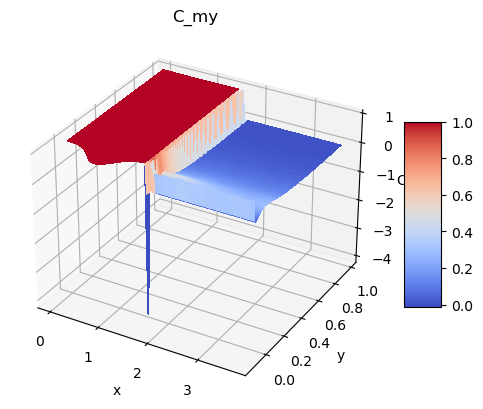

In [1461]:
# Plot 3D surface of C_my again
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x_center_average, y_center_average, c_my_tree.data, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('C_my')
ax.set_title('C_my')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [1462]:
# Randomly select training data from cmy_DNS, x_center_average & y_center_average arrays
# The training data is used to create the k-d tree
# The test data is used to test the k-d tree

# Training data
cmy_DNS_train = cmy_DNS.flatten()
x_center_average_train = x_center_average.flatten()
y_center_average_train = y_center_average.flatten()

cmy_DNS_train = np.array([cmy_DNS_train, x_center_average_train, y_center_average_train]).T

# Test data
cmy_DNS_test = cmy_DNS.flatten()
x_center_average_test = x_center_average.flatten()
y_center_average_test = y_center_average.flatten()

cmy_DNS_test = np.array([cmy_DNS_test, x_center_average_test, y_center_average_test]).T

/var/folders/19/k6d12h6s6hng1s70_0wscmh80000gn/T/ipykernel_71188/4040810127.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


ValueError: shape mismatch: objects cannot be broadcast to a single shape

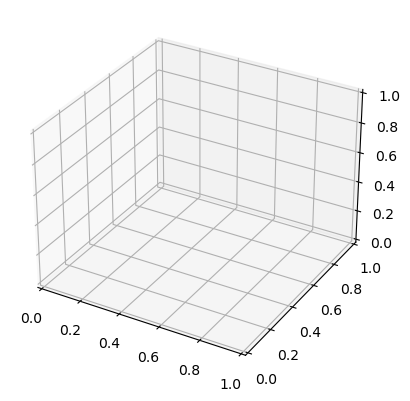

In [1464]:
# Plot 3D surface of training data to check if it is random
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x_center_average_train, y_center_average_train, cmy_DNS_train, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('C_my')
ax.set_title('C_my')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

# TODO
Fixa "outliers" datapunkter från DNS.
Kolla radien till 30 närmaste punkter -> om för stor, ändra till snittet av närliggande punkter.

Fråga Lars:
Varför beräkna nya cell centers?